In [13]:
import sys
sys.path.append('../')

In [14]:
import torchxrayvision as xrv
import torchvision
import torch
from torchvision import transforms
import os

from tqdm.auto import tqdm, trange
import numpy as np
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
import random
import seaborn as sns
%matplotlib inline

np.random.seed(19)
random.seed(19)

In [15]:
from src.chexnet import DenseNet121
from src.xrayvision import COVID19_Dataset

In [4]:
CKPT_PATH = '/Users/aniket/Google Drive/Projects/covid-research/checkpoints/chexnet/model.pth.tar'
N_CLASSES=14
DEVICE = torch.device('cpu')

In [5]:
import re

# Code modified from torchvision densenet source for loading from pre .4 densenet weights.
checkpoint = torch.load(CKPT_PATH, map_location=DEVICE)
state_dict = checkpoint['state_dict']
remove_data_parallel = True # Change if you don't want to use nn.DataParallel(model)

pattern = re.compile(
    r'^(.*denselayer\d+\.(?:norm|relu|conv))\.((?:[12])\.(?:weight|bias|running_mean|running_var))$')
for key in list(state_dict.keys()):
    match = pattern.match(key)
    new_key = match.group(1) + match.group(2) if match else key
    new_key = new_key[7:] if remove_data_parallel else new_key
    state_dict[new_key] = state_dict[key]
    # Delete old key only if modified.
    if match or remove_data_parallel: 
        del state_dict[key]

In [6]:
# initialize and load the model
model = DenseNet121(N_CLASSES)
# model = torch.nn.DataParallel(model)
model.load_state_dict(state_dict)
model = model.eval()

In [7]:
out_feats = model.densenet121.classifier[0].in_features
model.densenet121.classifier = torch.nn.Identity(out_feats)

In [8]:
# Dataset noramlized on
normalize = transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])

In [10]:
transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),xrv.datasets.XRayResizer(224)])

d_covid19 = COVID19_Dataset(
    '/Users/aniket/Google Drive/Projects/covid-research/data/covid-chestxray-dataset/images',
    '/Users/aniket/Google Drive/Projects/covid-research/data/covid-chestxray-dataset/metadata.csv',
    transform=transform,
    default_normalize=False
)

In [12]:
x = d_covid19[0]

In [100]:
idx = random.randint(0, len(d_covid19))
pil_image = d_covid19[idx]['image']
label = d_covid19[idx]['lab']
print('label:', label[3])

# image tensor
img_arr = pil_image.resize((224, 224), Image.BICUBIC)
img_arr = np.asarray(img_arr)
img_arr = img_arr.transpose(-1, 0, 1)
print(img_arr.shape)
img_tensor = normalize(torch.Tensor(img_arr))
img_tensor = img_tensor.expand(1, 3, 224, 224).detach()
model(img_tensor)

label: 1.0
(3, 224, 224)


tensor([[0.7515, 0.2196, 0.3359, 0.4949, 0.6119, 0.5860, 0.5114, 0.8238, 0.3913,
         0.2863, 0.9834, 0.5108, 0.5882, 0.3707]], grad_fn=<SigmoidBackward>)

In [136]:
features = []
labels = []
for idx in trange(len(d_covid19)):
    pil_image = d_covid19[idx]['image']
    label = d_covid19[idx]['lab']
    #print('label:', label[3])

    # image tensor
    img_arr = pil_image.resize((224, 224), Image.BICUBIC)
    img_arr = np.asarray(img_arr)
    img_arr = img_arr.transpose(-1, 0, 1)
    #print(img_arr.shape)
    img_tensor = normalize(torch.Tensor(img_arr))
    img_tensor = img_tensor.expand(1, 3, 224, 224).detach()

    feature = model(img_tensor)
    features.append(feature)
    labels.append(label[3])

In [180]:
X = []
for e in features:
    X.append(e.detach().numpy().reshape(1024))
X = np.asarray(X)
labels_ = np.asarray(labels)

## Split train test

In [157]:
X_ = X/7847.1504

In [351]:
split_pct = 0.8
indexes = list(range(len(X)))
random.shuffle(indexes)

train_idx = indexes[:int(split_pct*len(indexes))]
test_idx = indexes[int(split_pct*len(indexes)):]

print(len(train_idx), len(test_idx))

428 107


In [352]:
np.sum(labels_[train_idx]==1), np.sum(labels_[train_idx]==0)

(284, 144)

In [353]:
np.sum(labels_[test_idx]==1), np.sum(labels_[test_idx]==0)

(58, 49)

In [244]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, confusion_matrix

from sklearn.metrics import plot_confusion_matrix


In [308]:
knn = KNeighborsClassifier(n_neighbors=8, p=2)

In [309]:
knn.fit(X_[train_idx], labels_[train_idx])

KNeighborsClassifier(n_neighbors=8)

In [310]:
knn.score(X_[train_idx], labels_[train_idx])

0.6705607476635514

In [311]:
knn.score(X_[test_idx], labels_[test_idx])

0.6355140186915887

In [312]:
test_output = knn.predict(X_[test_idx])

In [313]:
precision_score(labels_[test_idx], test_output), recall_score(labels_[test_idx], test_output)

(0.7391304347826086, 0.7083333333333334)

In [314]:
f1_score(labels_[test_idx], test_output)

0.723404255319149

In [315]:
# knn.predict_proba(X_[test_idx])

In [316]:
precision, recall, thresh = precision_recall_curve(
                                labels_[test_idx],
                                knn.predict_proba(X_[test_idx])[..., 1]
                            )

In [317]:
precision

array([0.67924528, 0.6969697 , 0.68235294, 0.73913043, 0.76190476,
       0.86956522, 0.75      , 1.        ])

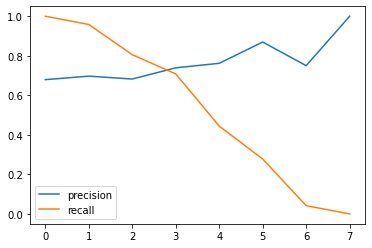

In [318]:
plt.plot(precision)
plt.plot(recall)

plt.legend(('precision', 'recall'))
plt.show()

In [319]:
cm = confusion_matrix(
        y_true=labels_[test_idx],
        y_pred=knn.predict(X_[test_idx])
    )

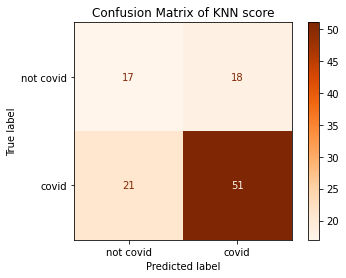

In [330]:
disp = plot_confusion_matrix(knn, X_[test_idx], labels_[test_idx], 
                          labels=(0, 1),
                          display_labels=('not covid', 'covid'),
                          cmap=plt.cm.Oranges
                         )

disp.ax_.set_title('Confusion Matrix of KNN score')
plt.savefig('../images/knn-confusion-matrix.png')
plt.show()